# Self Organising Textures
This notebook demonstrates the ability of NCA to learn self-organising textures.  Given a texture sample, the model learns to generate similar features (such as colours, lines, patterns and overall composition), without directly copying the input.  The idea is that the model learns to generate textures that are similar to the input, but are unique and can applied to an infinitely large surface.

## Imports
 - `numpy`
 - `torch`
 - `matplotlib` - Plotting loss graphs.
 - `IPython.display` - For displaying outputs within the notebook.

In [1]:
import PIL
import numpy as np
from IPython.display import clear_output, display, HTML
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Use GPU if available
USE_GPU = torch.cuda.is_available()
if (USE_GPU): torch.set_default_device('cuda')


## Loading the Target Image

The target image is first loaded, and then converted to a tensor. The tensor is then normalised to the range $[0, 1]$ and has the same shape as our NCA later.

` batches, channels, height, width`
 - Batches: 1
 - Channels: 3 (RGB)
 - Height/Width: Define by `SIZE`

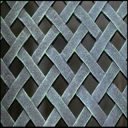

In [15]:
# Load target image
SIZE = 128
FILE = './weave.jpg' 

def load_image(file: str, size: int):
    # Resize image
    image = PIL.Image.open(file)
    image = image.convert('RGB')
    image = image.resize((size, size))
    display(image)

    # Convert image to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to tensor with shape (C, H, W) and scales pixel values to [0, 1]
    ])

    # Apply the transformation and add a batch dimension
    image = transform(image).unsqueeze(0)
    if (USE_GPU): image = image.cuda()

    return image

target = load_image(FILE, SIZE)

## Loss Function
The loss function is the most complicated and crucial part of developing self organising textures.  The final loss function is the sum of two separate loss functions.
1. **Overflow Loss** - Loss function that penalises the model for generating pixels that are too bright or too dark.
2. **VGG Loss** - Loss function that penalises the model for not generating textures that are similar to the target image.

### VGG Loss
The VGG loss is calculated by passing the generated image and the target image through a pre-trained VGG network. The VGG network is used to extract features from the images. The loss is then calculated as the squared error between random projections on the features of the generated image and the target image.  We use $n$ random projections to calculate the loss, as this greatly minimises the amount of work required to calculate the loss.

In [3]:
# Load the convolutional layers of a pre-trained VGG16 model (on ImageNet)
vgg = models.vgg16(weights='IMAGENET1K_V1').features

# Layers to extract features from
STYLE_LAYERS = [1, 6, 11, 18, 25]

# Mean and Standard Deviation of ImageNet dataset
MEAN = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
STD = torch.tensor([0.229, 0.224, 0.225])[:, None, None]

def extract_vgg_features(imgs: np.array):
    # Normalise images to ImageNet mean and standard deviation
    x = (imgs - MEAN) / STD

    # Reshape to batches of channels of images
    batches, channels, height, width = x.shape
    features = [x.reshape(batches, channels, height*width)]

    # Extract features from a forward pass through each style layer (up to the last layer we need)
    for i, layer in enumerate(vgg[:max(STYLE_LAYERS)+1]):
        x = layer(x)

        # Save relevant features
        if i in STYLE_LAYERS:
            batches, channels, height, width = x.shape
            features.append(x.reshape(batches, channels, height*width))

    return features

def optimal_transport_loss(sample: torch.Tensor, target: torch.Tensor, projections_n = 32) -> torch.Tensor:
    channels, n = sample.shape[-2:]

    # Generate n random projections for each channel
    projections = F.normalize(torch.randn(channels, projections_n), dim=0)

    # Project samples and target onto random projections and sort
    sample_projections = sorted_projections(sample, projections)
    target_projections = sorted_projections(target, projections)

    # Interpolate target projections to match sample size
    target_interpolation = F.interpolate(target_projections, size=n, mode='nearest')

    # Calculate optimal transport loss from the squared error between the two projection distributions
    return (sample_projections - target_interpolation).square().sum()

def sorted_projections(x, proj):
  # Project samples onto random projections and sort
  # Calculate the dot product of each pixel with each projection
  # x: (b: batch, c: channels, n: pixels)
  # proj: (c: channels, p: projections_n)
  # output: (b: batch, p: projections_n, n: pixels)
  # Finally, sort the projections so they can be aligned with the target distribution
  return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

def create_vgg_loss_fn(target: torch.Tensor):
    # Extract features from target image
    target_features = extract_vgg_features(target)

    # Define loss function
    def vgg_loss_fn(sample: torch.Tensor) -> torch.Tensor:
        sample_features = extract_vgg_features(sample)

        # Calculate optimal transport loss between each pair of features
        loss = sum(optimal_transport_loss(x, y) for x, y in zip(sample_features, target_features))
        return loss

    return vgg_loss_fn
    

## Training Setup
 - Initialising the model
 - Setting up the optimiser and learning rate scheduler

In [4]:
from model import SelfOrganisingTexture

model = SelfOrganisingTexture()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01, capturable=True)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[500, 1000], gamma=0.3)

# Initialise 256 samples for batch training
with torch.no_grad():
  loss_fn = create_vgg_loss_fn(target)
  pool = model.seed(256)

## Training Loop
In a given iteration of the training loop, the following steps are performed:
1. Select a random sample of NCA states from the pool.
2. Iterate over the NCA states with the current weights of the model a random number of times.
3. Calculate the loss and backpropagate the gradients.

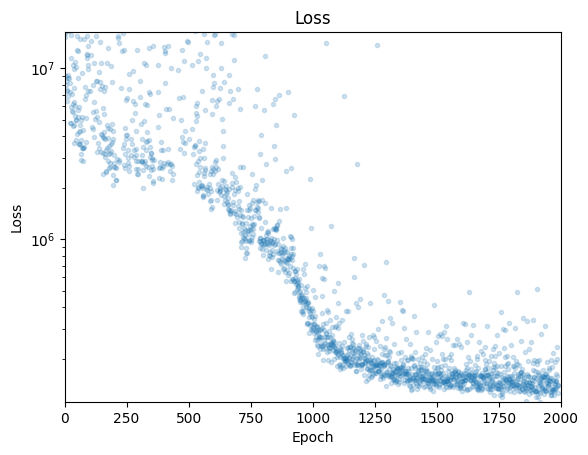

In [5]:
EPOCHS = 2000
BATCH_SIZE = 4

# Plot losses
losses = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for epoch in range(EPOCHS):
    with torch.no_grad():
        # Select a random batch of samples from the pool
        batch_idx = np.random.choice(len(pool), BATCH_SIZE, replace=False)
        x = pool[batch_idx]

        # Every 8 epochs, seed the model with a new sample
        if epoch % 8 == 0:
            x[:1] = model.seed(1)

    # Run the model for a random number of steps
    steps = np.random.randint(32, 96)
    for i in range(steps):
        x = model(x)

    # Calculate loss = overflow loss + VGG loss
    overflow_loss = (x - x.clamp(-1.0, 1.0)).abs().sum()
    vgg_loss = loss_fn(model.rgb(x))
    loss = overflow_loss + vgg_loss
    losses.append(loss.item())

    # Backpropagate and update model
    with torch.no_grad():
        loss.backward()

        # Normalise gradients and add a small value to the denominator to avoid division by zero
        for param in model.parameters():
            param.grad /= (param.grad.norm() + 1e-8)
    
        optimiser.step()
        optimiser.zero_grad()
        lr_scheduler.step()

        # Update the pool with the new samples
        pool[batch_idx] = x

        # Update loss plot
        if epoch % 10 == 0:
            ax.cla()
            ax.set_yscale('log')
            ax.set_xlim(0, EPOCHS)
            ax.set_ylim(min(losses), losses[0])
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_title('Loss')
            ax.plot(losses, '.', alpha=0.2)
            display(fig)

            # Clear the output and display the plot
            clear_output(wait=True)
        

## Video Generation

Finally, we can generate a video of the texture generation process.  A texture usually emerges after ~30 iterations, and will become more stable as time goes on.
The video is saved as `webp` format, which is a lossless and more efficient format than `gif`.

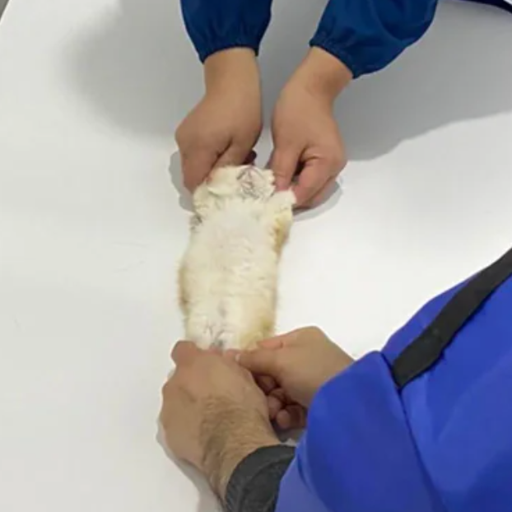

In [25]:
STEPS = 100
SIZE = 512
FPS = 10

frames = []

with torch.no_grad():
    initial_img = load_image('./cat.png', SIZE)
    x = model.seed(1, SIZE)

    # Assign image to RGB channels of seed
    x[:, :3, :, :] = initial_img

    for i in range(STEPS):
        x = model(x)

        # Process the image
        img = model.rgb(x)
        img = transforms.ToPILImage()(img[0])
        
        # Append the frame to the list
        frames.append(img)

# Create a video from the collected frames
path = 'texture.webp'
frames[0].save(path, save_all=True, append_images=frames[1:], optimize=True, duration=1000/FPS, loop=0)

# Display the video
display(HTML(f'<img src="{path}" type="image/webp" width="{SIZE}px"/>'))